In [70]:
# import the usual
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import hashlib 
import datetime
import surprise
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model
from surprise import SVD
from sklearn import preprocessing
%matplotlib inline
pd.set_option('display.max_columns', 500)

Using TensorFlow backend.


### LastFm Data Loading

In [2]:
%%time
df = pd.read_csv("../../Dataset/lastfm/userid-timestamp-artid-artname-traid-traname.tsv", sep="\t", error_bad_lines=False, header = None)

b'Skipping line 2120260: expected 6 fields, saw 8\n'
b'Skipping line 2446318: expected 6 fields, saw 8\n'
b'Skipping line 11141081: expected 6 fields, saw 8\n'
b'Skipping line 11152099: expected 6 fields, saw 12\nSkipping line 11152402: expected 6 fields, saw 8\n'
b'Skipping line 11882087: expected 6 fields, saw 8\n'
b'Skipping line 12902539: expected 6 fields, saw 8\nSkipping line 12935044: expected 6 fields, saw 8\n'
b'Skipping line 17589539: expected 6 fields, saw 8\n'


CPU times: user 30.6 s, sys: 4.88 s, total: 35.5 s
Wall time: 37 s


In [3]:
df.columns = ['userid', 'timestamp', 'artistid', 'artist', '1', 'song']

In [4]:
df.head()

,userid,timestamp,artistid,artist,1,song
0,user_000001,2009-05-04T23:08:57Z,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04T13:54:10Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04T13:52:04Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04T13:42:52Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04T13:42:11Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)


In [5]:
df['time'] = pd.to_datetime(df['timestamp'])
df.drop(['timestamp'], axis=1, inplace=True)

In [6]:
df.head()

,userid,artistid,artist,1,song,time
0,user_000001,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007,2009-05-04 23:08:57+00:00
1,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15),2009-05-04 13:54:10+00:00
2,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15),2009-05-04 13:52:04+00:00
3,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15),2009-05-04 13:42:52+00:00
4,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15),2009-05-04 13:42:11+00:00


### Removing artist name and song id (possibly) from the user_songs_df dataframe

In [7]:
user_songs_df = df.drop(['artist'], axis=1, inplace=False)
user_songs_df.columns = ['userid', 'artistid', 'songid', 'song', 'time']
user_songs_df = user_songs_df.drop(['songid'], axis=1, inplace=False)

In [8]:
user_songs_df.head()

,userid,artistid,song,time
0,user_000001,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007,2009-05-04 23:08:57+00:00
1,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,Composition 0919 (Live_2009_4_15),2009-05-04 13:54:10+00:00
2,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,Mc2 (Live_2009_4_15),2009-05-04 13:52:04+00:00
3,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,Hibari (Live_2009_4_15),2009-05-04 13:42:52+00:00
4,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,Mc1 (Live_2009_4_15),2009-05-04 13:42:11+00:00


In [9]:
print('Number of songs : ' + str(user_songs_df['song'].nunique()))

Number of songs : 1083471


In [10]:
def get_unique_count(column):
    return len(set(column))

### Filtering songs heard by at least 10 users

In [11]:
# df_songs_heard_10_users = user_songs_df.groupby("song").filter(lambda x: get_unique_count(x['userid'])>10)

KeyboardInterrupt: 

In [ ]:
# df_songs_heard_10_users.head()

In [ ]:
# print('Number of songs heard by at least 10 users : ' + str(df_songs_heard_10_users['song'].nunique()))
# print('Number of users in this dataframe : ' + str(df_songs_heard_10_users['userid'].nunique()))

### Filtering songs heard by at least 100 users

In [12]:
df_songs_heard_100_users = user_songs_df.groupby("song").filter(lambda x: get_unique_count(x['userid'])>100)

In [13]:
df_songs_heard_100_users.head()

,userid,artistid,song,time
22,user_000001,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-05-03 14:39:20+00:00
26,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Seven,2009-05-03 14:07:40+00:00
28,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Five,2009-05-03 13:56:25+00:00
30,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Three,2009-05-03 13:40:46+00:00
39,user_000001,3d05eb8b-1644-4143-9a61-b28e33c4d85f,Something In The Way,2009-05-02 15:19:46+00:00


In [14]:
print('Number of songs heard by at least 100 users : ' + str(df_songs_heard_100_users['song'].nunique()))
print('Number of users in this dataframe : ' + str(df_songs_heard_100_users['userid'].nunique()))

Number of songs heard by at least 100 users : 4034
Number of users in this dataframe : 990


### Creation of timeslots

In [15]:
df_songs_heard_100_users['hour'] = df_songs_heard_100_users['time'].dt.hour

/Users/akshayj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
df_songs_heard_100_users.head()

,userid,artistid,song,time,hour
22,user_000001,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-05-03 14:39:20+00:00,14
26,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Seven,2009-05-03 14:07:40+00:00,14
28,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Five,2009-05-03 13:56:25+00:00,13
30,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Three,2009-05-03 13:40:46+00:00,13
39,user_000001,3d05eb8b-1644-4143-9a61-b28e33c4d85f,Something In The Way,2009-05-02 15:19:46+00:00,15


In [17]:
#function to return slot number
def slot(hour):
    if 0 <= hour and hour <= 5:
        return 1
    elif 6 <= hour and hour <= 11:
        return 2
    elif 12 <= hour and hour <= 17:
        return 3
    else:
        return 4

In [18]:
%%time
df_songs_heard_100_users['slot'] = df_songs_heard_100_users['hour'].apply( lambda x : slot(x) ) 

CPU times: user 1.81 s, sys: 69.1 ms, total: 1.88 s
Wall time: 1.47 s


/Users/akshayj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df_songs_heard_100_users.head()

,userid,artistid,song,time,hour,slot
22,user_000001,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-05-03 14:39:20+00:00,14,3
26,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Seven,2009-05-03 14:07:40+00:00,14,3
28,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Five,2009-05-03 13:56:25+00:00,13,3
30,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Three,2009-05-03 13:40:46+00:00,13,3
39,user_000001,3d05eb8b-1644-4143-9a61-b28e33c4d85f,Something In The Way,2009-05-02 15:19:46+00:00,15,3


In [20]:
df_songs_heard_100_users.shape

(3922101, 6)

#### Creating song ids

In [21]:
df_songs_heard_100_users['songid'] = df_songs_heard_100_users.groupby(['song']).ngroup().add(1)

/Users/akshayj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
df_songs_heard_100_users['userid'] = df_songs_heard_100_users.groupby(['userid']).ngroup().add(1)

/Users/akshayj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [84]:
df_songs_heard_100_users.head()

,userid,artistid,song,time,hour,slot,songid
22,1,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-05-03 14:39:20+00:00,14,3,619
26,1,ce559a88-58ba-4d8a-8456-9177412d609c,Seven,2009-05-03 14:07:40+00:00,14,3,2896
28,1,ce559a88-58ba-4d8a-8456-9177412d609c,Five,2009-05-03 13:56:25+00:00,13,3,1099
30,1,ce559a88-58ba-4d8a-8456-9177412d609c,Three,2009-05-03 13:40:46+00:00,13,3,3565
39,1,3d05eb8b-1644-4143-9a61-b28e33c4d85f,Something In The Way,2009-05-02 15:19:46+00:00,15,3,3061


In [85]:
df_songs_heard_100_users[df_songs_heard_100_users['song'] == 'Clouds']

,userid,artistid,song,time,hour,slot,songid
22,1,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-05-03 14:39:20+00:00,14,3,619
212,1,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-04-28 13:18:42+00:00,13,3,619
264,1,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-04-26 18:37:07+00:00,18,4,619
280,1,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-04-26 17:07:08+00:00,17,3,619
1067,1,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-04-11 15:53:03+00:00,15,3,619
...,...,...,...,...,...,...,...
18990426,985,1dcc8968-f2cd-441c-beda-6270f70f2863,Clouds,2006-08-06 10:32:53+00:00,10,2,619
19012117,987,24ed5b09-02b1-47fe-bd83-6fa5270039b0,Clouds,2007-01-31 02:35:11+00:00,2,1,619
19012489,987,24ed5b09-02b1-47fe-bd83-6fa5270039b0,Clouds,2007-01-30 00:31:13+00:00,0,1,619
19012885,987,24ed5b09-02b1-47fe-bd83-6fa5270039b0,Clouds,2007-01-27 17:27:21+00:00,17,3,619


In [86]:
# Removing artistid, time and hour columns
input_dataset = df_songs_heard_100_users.drop(['artistid', 'song', 'time','hour'], axis=1, inplace=False)

In [87]:
input_dataset = input_dataset[['userid', 'songid', 'slot']]

In [88]:
input_dataset.head()

,userid,songid,slot
22,1,619,3
26,1,2896,3
28,1,1099,3
30,1,3565,3
39,1,3061,3


### Generating training and testing data

In [89]:
#Group by users and get the size of each group
user_record_counts = input_dataset.groupby("userid").apply(lambda x: x.shape[0])

In [90]:
#Divide dataset into train and test based on users and the number of the songs listened
train_set_keys = []
test_set_keys = []
sum_val = 0
total = input_dataset.shape[0]
for key, value in user_record_counts.items():
    sum_val += value
    fraction = sum_val/total
    if fraction <= 0.8:
        train_set_keys.append(key)        
    else:
        test_set_keys.append(key)

In [91]:
print("Number of users in train set : "+str(len(train_set_keys)))
print("Number of users in test set : "+str(len(test_set_keys)))

Number of users in train set : 792
Number of users in test set : 198


In [92]:
train_set = input_dataset.groupby("userid").filter(lambda x: x['userid'].iloc[0] in train_set_keys)
test_set = input_dataset.groupby("userid").filter(lambda x: x['userid'].iloc[0] in test_set_keys)

In [93]:
print("Number of users in train set : "+str(train_set['userid'].nunique()))
print("Number of users in test set : "+str(test_set['userid'].nunique()))

Number of users in train set : 792
Number of users in test set : 198


In [94]:
print('Fraction of train set : ' + str(train_set.shape[0]/total))

Fraction of train set : 0.7984888711432979


In [330]:
train_set.head()

,userid,songid,slot
22,1,619,3
26,1,2896,3
28,1,1099,3
30,1,3565,3
39,1,3061,3


### Creating train dataframes based on slots

In [96]:
grouped_train_set = train_set.groupby('slot')
grouped_test_set = test_set.groupby('slot')

In [97]:
train_first_slot_df = grouped_train_set.get_group(1)
train_second_slot_df = grouped_train_set.get_group(2)
train_third_slot_df = grouped_train_set.get_group(3)
train_fourth_slot_df = grouped_train_set.get_group(4)

test_first_slot_df = grouped_test_set.get_group(1)
test_second_slot_df = grouped_test_set.get_group(2)
test_third_slot_df = grouped_test_set.get_group(3)
test_fourth_slot_df = grouped_test_set.get_group(4)

In [98]:
# train_first_slot_df

In [99]:
print('First train slot shape : ' + str(train_first_slot_df.shape))
print('Second train slot shape : ' + str(train_second_slot_df.shape))
print('Third train slot shape : ' + str(train_third_slot_df.shape))
print('Fourth train slot shape : ' + str(train_fourth_slot_df.shape))
print('')
print("Number of users in train_first_slot_df : " + str(train_first_slot_df['userid'].nunique()))
print("Number of users in train_second_slot_df : " + str(train_second_slot_df['userid'].nunique()))
print("Number of users in train_third_slot_df : " + str(train_third_slot_df['userid'].nunique()))
print("Number of users in train_fourth_slot_df : " + str(train_fourth_slot_df['userid'].nunique()))
print('')
print("Number of songs in train_first_slot_df : " + str(train_first_slot_df['songid'].nunique()))
print("Number of songs in train_second_slot_df : " + str(train_second_slot_df['songid'].nunique()))
print("Number of songs in train_third_slot_df : " + str(train_third_slot_df['songid'].nunique()))
print("Number of songs in train_fourth_slot_df : " + str(train_fourth_slot_df['songid'].nunique()))
print('')
print('First test slot shape : ' + str(test_first_slot_df.shape))
print('Second test slot shape : ' + str(test_second_slot_df.shape))
print('Third test slot shape : ' + str(test_third_slot_df.shape))
print('Fourth test slot shape : ' + str(test_fourth_slot_df.shape))
print('')
print("Number of users in test_first_slot_df : " + str(test_first_slot_df['userid'].nunique()))
print("Number of users in test_second_slot_df : " + str(test_second_slot_df['userid'].nunique()))
print("Number of users in test_third_slot_df : " + str(test_third_slot_df['userid'].nunique()))
print("Number of users in test_fourth_slot_df : " + str(test_fourth_slot_df['userid'].nunique()))
print('')
print("Number of songs in test_first_slot_df : " + str(test_first_slot_df['songid'].nunique()))
print("Number of songs in test_second_slot_df : " + str(test_second_slot_df['songid'].nunique()))
print("Number of songs in test_third_slot_df : " + str(test_third_slot_df['songid'].nunique()))
print("Number of songs in test_fourth_slot_df : " + str(test_fourth_slot_df['songid'].nunique()))


First train slot shape : (596866, 3)
Second train slot shape : (544262, 3)
Third train slot shape : (943222, 3)
Fourth train slot shape : (1047404, 3)

Number of users in train_first_slot_df : 737
Number of users in train_second_slot_df : 762
Number of users in train_third_slot_df : 784
Number of users in train_fourth_slot_df : 780

Number of songs in train_first_slot_df : 4034
Number of songs in train_second_slot_df : 4034
Number of songs in train_third_slot_df : 4034
Number of songs in train_fourth_slot_df : 4034

First test slot shape : (173856, 3)
Second test slot shape : (146390, 3)
Third test slot shape : (221677, 3)
Fourth test slot shape : (248424, 3)

Number of users in test_first_slot_df : 185
Number of users in test_second_slot_df : 188
Number of users in test_third_slot_df : 191
Number of users in test_fourth_slot_df : 193

Number of songs in test_first_slot_df : 4034
Number of songs in test_second_slot_df : 4034
Number of songs in test_third_slot_df : 4034
Number of songs 

In [191]:
# Get user-song-count dataframe for each slot
train_user_song_count_df_first = train_first_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")
train_user_song_count_df_second = train_second_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")
train_user_song_count_df_third = train_third_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")
train_user_song_count_df_fourth = train_fourth_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")

test_user_song_count_df_first = test_first_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")
test_user_song_count_df_second = test_second_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")
test_user_song_count_df_third = test_third_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")
test_user_song_count_df_fourth = test_fourth_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")

In [192]:
# train_user_song_count_df_first = train_first_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")

In [193]:
train_user_song_count_df_first.head()

,userid,songid,count
0,1,10,2
1,1,27,4
2,1,43,1
3,1,91,1
4,1,137,2


In [215]:
def get_rating(x):
    x['rating'] = pd.cut(x['count'], 5, labels=[1,2,3,4,5], right=True)
    return x

In [225]:
train_user_song_count_df_first = train_user_song_count_df_first.groupby("userid").apply(lambda x : get_rating(x))
train_user_song_count_df_second = train_user_song_count_df_second.groupby("userid").apply(lambda x : get_rating(x))
train_user_song_count_df_third = train_user_song_count_df_third.groupby("userid").apply(lambda x : get_rating(x))
train_user_song_count_df_fourth = train_user_song_count_df_fourth.groupby("userid").apply(lambda x : get_rating(x))

test_user_song_count_df_first = test_user_song_count_df_first.groupby("userid").apply(lambda x : get_rating(x))
test_user_song_count_df_second = test_user_song_count_df_second.groupby("userid").apply(lambda x : get_rating(x))
test_user_song_count_df_third = test_user_song_count_df_third.groupby("userid").apply(lambda x : get_rating(x))
test_user_song_count_df_fourth = test_user_song_count_df_fourth.groupby("userid").apply(lambda x : get_rating(x))

In [227]:
train_user_song_count_df_fourth.head()

,userid,songid,count,rating
0,1,10,1,1
1,1,171,1,1
2,1,203,1,1
3,1,398,1,1
4,1,409,1,1


In [233]:
train_user_song_count_df_first.drop(['count'], axis=1, inplace=True)
train_user_song_count_df_second.drop(['count'], axis=1, inplace=True)
train_user_song_count_df_third.drop(['count'], axis=1, inplace=True)
train_user_song_count_df_fourth.drop(['count'], axis=1, inplace=True)

test_user_song_count_df_first.drop(['count'], axis=1, inplace=True)
test_user_song_count_df_second.drop(['count'], axis=1, inplace=True)
test_user_song_count_df_third.drop(['count'], axis=1, inplace=True)
test_user_song_count_df_fourth.drop(['count'], axis=1, inplace=True)

In [234]:
train_user_song_count_df_first.head()

,userid,songid,rating
0,1,10,2
1,1,27,4
2,1,43,1
3,1,91,1
4,1,137,2


In [308]:
train_user_song_count_df_first['rating'] = train_user_song_count_df_first['rating'].astype('int')
train_user_song_count_df_second['rating'] = train_user_song_count_df_second['rating'].astype('int')
train_user_song_count_df_third['rating'] = train_user_song_count_df_third['rating'].astype('int')
train_user_song_count_df_fourth['rating'] = train_user_song_count_df_fourth['rating'].astype('int')

test_user_song_count_df_first['rating'] = test_user_song_count_df_first['rating'].astype('int')
test_user_song_count_df_second['rating'] = test_user_song_count_df_second['rating'].astype('int')
test_user_song_count_df_third['rating'] = test_user_song_count_df_third['rating'].astype('int')
test_user_song_count_df_fourth['rating'] = test_user_song_count_df_fourth['rating'].astype('int')

In [309]:
train_user_song_count_df_first.head()

,userid,songid,rating
0,1,10,2
1,1,27,4
2,1,43,1
3,1,91,1
4,1,137,2


## *** Use these dataframes ***

In [101]:
# train_user_song_count_df_first
# train_user_song_count_df_second
# train_user_song_count_df_third
# train_user_song_count_df_fourth

# test_user_song_count_df_first
# test_user_song_count_df_second
# test_user_song_count_df_third
# test_user_song_count_df_fourth

## Keras

In [237]:
train_user_song_count_df_first.head()

,userid,songid,rating
0,1,10,2
1,1,27,4
2,1,43,1
3,1,91,1
4,1,137,2


In [238]:
test_user_song_count_df_first.head()

,userid,songid,rating
0,793,2,1
1,793,5,1
2,793,14,1
3,793,51,1
4,793,64,1


In [332]:
n_users = input_dataset['userid'].max()
n_songs = len(train_user_song_count_df_first.songid.unique())

In [333]:
print(n_users)
print(n_songs)

990
4034


### Creating dot product model

In [334]:
# creating song embedding path
songs_input = Input(shape=[1], name="Songs-Input")
song_embedding = Embedding(n_songs+1, 5, name="Songs-Embedding")(songs_input)
song_vec = Flatten(name="Flatten-Song")(song_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([song_vec, user_vec])
model = Model([user_input, songs_input], prod)
model.compile('adam', 'mean_squared_error')

/Users/akshayj/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
196612/196612 [==============================] - 5s 24us/step - loss: 0.9807
Epoch 2/5
196612/196612 [==============================] - 5s 23us/step - loss: 0.3622
Epoch 3/5
196612/196612 [==============================] - 5s 23us/step - loss: 0.3383
Epoch 4/5
196612/196612 [==============================] - 4s 22us/step - loss: 0.3296
Epoch 5/5
196612/196612 [==============================] - 4s 22us/step - loss: 0.3247


Text(0, 0.5, 'Training Error')

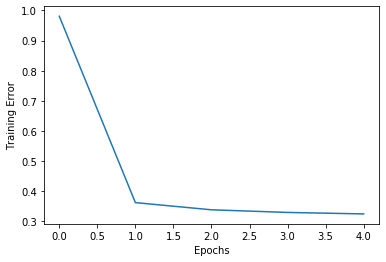

In [335]:
from keras.models import load_model
import os 
history = model.fit([train_user_song_count_df_first['userid'], train_user_song_count_df_first['songid']], train_user_song_count_df_first['rating'], epochs=5, verbose=1)
model.save('regression_model.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [336]:
# [0.00196864] 0.0
# [-0.00012866] 0.002325581395348837
# [-0.00186123] 0.002325581395348837
# [-0.00570821] 0.002325581395348837
# [0.00340688] 0.0
# [-0.00189093] 0.0069767441860465115
# [-0.00176162] 0.05116279069767442
# [-0.004316] 0.002325581395348837
# [-0.00244239] 0.0069767441860465115
# [-0.00261529] 0.04186046511627907

In [337]:
predictions = model.predict([test_user_song_count_df_first.userid.head(10), test_user_song_count_df_first.songid.head(10)])

[print(predictions[i], test_user_song_count_df_first['rating'].iloc[i]) for i in range(0,10)]

[0.03420264] 1
[0.03669845] 1
[0.02740088] 1
[0.03049977] 1
[0.03300446] 1
[0.0396337] 1
[0.03225631] 4
[0.03922938] 1
[0.03719599] 1
[0.04463234] 3


[None, None, None, None, None, None, None, None, None, None]

In [380]:
model.evaluate([test_user_song_count_df_first.userid, test_user_song_count_df_first.songid], test_user_song_count_df_first.rating)


51240/51240 [==============================] - 1s 10us/step


1.7292450973710263

In [398]:
# creating song embedding path
songs_input = Input(shape=[1], name="Songs-Input")
songs_embedding = Embedding(n_songs+1, 5, name="Songs-Embedding")(songs_input)
songs_vec = Flatten(name="Flatten-Songs")(songs_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([songs_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model_1 = Model([user_input, songs_input], out)
model_1.compile('adam', 'mean_squared_error')

model_2 = Model([user_input, songs_input], out)
model_2.compile('adam', 'mean_squared_error')

model_3 = Model([user_input, songs_input], out)
model_3.compile('adam', 'mean_squared_error')

model_4 = Model([user_input, songs_input], out)
model_4.compile('adam', 'mean_squared_error')

/Users/akshayj/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
196612/196612 [==============================] - 6s 32us/step - loss: 0.3443
Epoch 2/5
196612/196612 [==============================] - 6s 30us/step - loss: 0.3239
Epoch 3/5
196612/196612 [==============================] - 6s 30us/step - loss: 0.3124
Epoch 4/5
196612/196612 [==============================] - 6s 30us/step - loss: 0.3011
Epoch 5/5
196612/196612 [==============================] - 6s 30us/step - loss: 0.2922


/Users/akshayj/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
204207/204207 [==============================] - 6s 31us/step - loss: 0.3153
Epoch 2/5
204207/204207 [==============================] - 6s 30us/step - loss: 0.3007
Epoch 3/5
204207/204207 [==============================] - 6s 30us/step - loss: 0.2900
Epoch 4/5
204207/204207 [==============================] - 6s 29us/step - loss: 0.2809
Epoch 5/5
204207/204207 [==============================] - 6s 29us/step - loss: 0.2718


/Users/akshayj/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
293210/293210 [==============================] - 9s 31us/step - loss: 0.2890
Epoch 2/5
293210/293210 [==============================] - 9s 31us/step - loss: 0.2774
Epoch 3/5
293210/293210 [==============================] - 9s 31us/step - loss: 0.2683
Epoch 4/5
293210/293210 [==============================] - 9s 32us/step - loss: 0.2601
Epoch 5/5
293210/293210 [==============================] - 9s 31us/step - loss: 0.2538


/Users/akshayj/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
306899/306899 [==============================] - 10s 31us/step - loss: 0.2728
Epoch 2/5
306899/306899 [==============================] - 9s 31us/step - loss: 0.2623
Epoch 3/5
306899/306899 [==============================] - 9s 31us/step - loss: 0.2539
Epoch 4/5
306899/306899 [==============================] - 9s 31us/step - loss: 0.2475
Epoch 5/5
306899/306899 [==============================] - 9s 31us/step - loss: 0.2427


Text(0, 0.5, 'Training Error')

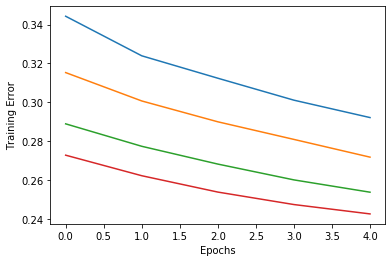

In [399]:
from keras.models import load_model

history = model_1.fit([train_user_song_count_df_first['userid'], train_user_song_count_df_first['songid']], train_user_song_count_df_first['rating'], epochs=5, verbose=1, shuffle=False)
model_1.save('regression_model_1.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

history = model_2.fit([train_user_song_count_df_second['userid'], train_user_song_count_df_second['songid']], train_user_song_count_df_second['rating'], epochs=5, verbose=1, shuffle=False)
model_2.save('regression_model_2.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

history = model_3.fit([train_user_song_count_df_third['userid'], train_user_song_count_df_third['songid']], train_user_song_count_df_third['rating'], epochs=5, verbose=1, shuffle=False)
model_3.save('regression_model_3.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

history = model_4.fit([train_user_song_count_df_fourth['userid'], train_user_song_count_df_fourth['songid']], train_user_song_count_df_fourth['rating'], epochs=5, verbose=1, shuffle=False)
model_4.save('regression_model_4.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [400]:
print('Slot 1 RMSE : ' + str(model_1.evaluate([test_user_song_count_df_first.userid, test_user_song_count_df_first.songid], test_user_song_count_df_first.rating)))
print('Slot 2 RMSE : ' + str(model_2.evaluate([test_user_song_count_df_second.userid, test_user_song_count_df_second.songid], test_user_song_count_df_second.rating)))
print('Slot 3 RMSE : ' + str(model_3.evaluate([test_user_song_count_df_third.userid, test_user_song_count_df_third.songid], test_user_song_count_df_third.rating)))
print('Slot 4 RMSE : ' + str(model_4.evaluate([test_user_song_count_df_fourth.userid, test_user_song_count_df_fourth.songid], test_user_song_count_df_fourth.rating)))


51240/51240 [==============================] - 1s 11us/step
Slot 1 RMSE : 0.35050526212240735
54255/54255 [==============================] - 1s 12us/step
Slot 2 RMSE : 0.3596928691899169
70612/70612 [==============================] - 1s 12us/step
Slot 3 RMSE : 0.32899121536226955
72669/72669 [==============================] - 1s 11us/step
Slot 4 RMSE : 0.34086530805651166


## Prediction

In [414]:
%%time
test_set = [test_user_song_count_df_first, test_user_song_count_df_second, test_user_song_count_df_third, test_user_song_count_df_fourth]
model_set = [model_1, model_2, model_3, model_4]
output_list = []
# predict using test data
results = []
for item, model in zip(test_set, model_set):
    output = pd.DataFrame(columns = ['userid', 'songid','rating'])
    for index, row in item.iterrows():
        predictions = model.predict([[row['userid']], [[row['songid']]]])
        predicted_rating = predictions[0][0]
#         recommended_song_ids = (-predictions).argsort()[:10]
#         recommended_song_ids
#         prediction = algo.predict(row['userid'], row['songid'], verbose=False)
#         predicted_rating = prediction.est
        output = output.append(pd.Series([str(row['userid']), str(row['songid']), predicted_rating], index=output.columns), ignore_index=True)
    output_list.append(output)

CPU times: user 18min 43s, sys: 16.5 s, total: 18min 59s
Wall time: 18min 27s


In [415]:
output_list[0]

,userid,songid,rating
0,793,2,1.867255
1,793,5,1.147377
2,793,14,1.256216
3,793,51,1.124850
4,793,64,1.225819
...,...,...,...
51235,990,4024,1.186832
51236,990,4025,1.601822
51237,990,4027,1.154954
51238,990,4030,1.259014


## Calculate precision

In [601]:
def calculate_precision(actual, prediction):
    mean = actual['rating'].mean()
    relevant = set(np.array(actual[actual['rating']>=(mean/1.3)]['songid'].astype('int')))
    recommended = set(np.array(prediction.nlargest(30, ['rating'])['songid'].astype('int')))
    precision = len(recommended & relevant)/len(recommended)
    return precision

## Calculate Recall

In [602]:
def calculate_recall(actual, prediction):
    mean = actual['rating'].mean()
    relevant = set(np.array(actual[actual['rating']>=(mean/1.3)]['songid'].astype('int')))
    recommended = set(np.array(prediction.nlargest(30, ['rating'])['songid'].astype('int')))
    if len(relevant) == 0:
        recall = 0
    else:
        recall = len(recommended & relevant)/len(relevant)
    return recall

## Evaluation

In [603]:
def evaluation(actual, predictions):
    precision_sum = 0
    recall_sum = 0
    actual_grouped_by_user = actual.groupby('userid') 
    predictions_grouped_by_user = predictions.groupby('userid')
    number_of_users = len(actual_grouped_by_user)
    actual_key_list = actual_grouped_by_user.groups.keys()
#     number_of_users *= 0.5
    actual_val_list = []
    for item in actual_key_list:
        actual_val_list.append(actual_grouped_by_user.get_group(item))
        
    predictions_key_list = predictions_grouped_by_user.groups.keys()
    predictions_val_list = []
    for item in predictions_key_list:
        predictions_val_list.append(predictions_grouped_by_user.get_group(item))    
    for actual_group, pred_group in zip(actual_val_list, predictions_val_list):
        precision_sum += calculate_precision(actual_group, pred_group)
        recall_sum += calculate_recall(actual_group, pred_group)
    precision = precision_sum/number_of_users
    recall = recall_sum/number_of_users
    return precision, recall

In [604]:
precision_list = []
recall_list = []
for actual_df, prediction_df in zip(test_set, output_list):
    precision, recall = evaluation(actual_df, prediction_df)
    precision_list.append(precision)
    recall_list.append(recall)
    

In [605]:
precision_list

[0.8034861311960265,
 0.8155454425401235,
 0.8303661100555848,
 0.8627277155774566]

In [606]:
recall_list

[0.4039593076661162,
 0.3170775298623393,
 0.22937320203114045,
 0.23724851503904415]

In [607]:
f1_list = []
for i in range(4):
    f1_list.append((2*precision_list[i]*recall_list[i])/(precision_list[i]+recall_list[i]))

In [608]:
f1_list

[0.5376237978639311,
 0.4566235026340676,
 0.3594539361695491,
 0.3721550770039121]

## Plot bar graph

In [613]:
def plot_bar(label, x_label, y_label, title, values):
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, values)
    plt.ylim(top=1)    
    plt.xlabel(x_label, fontsize=10)
    plt.ylabel(y_label, fontsize=10)
    plt.xticks(index, label, fontsize=10, rotation=0)
    plt.title(title)
    plt.show()

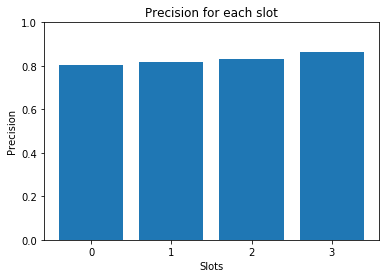

In [614]:
label = [i for i in range(len(precision_list))]
plot_bar(label, 'Slots', 'Precision', 'Precision for each slot', precision_list)

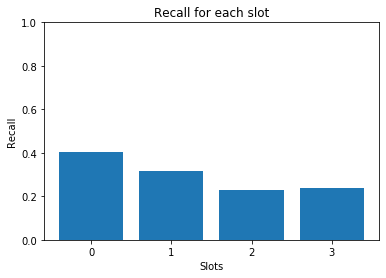

In [615]:
label = [i for i in range(len(recall_list))]
plot_bar(label, 'Slots', 'Recall', 'Recall for each slot', recall_list)

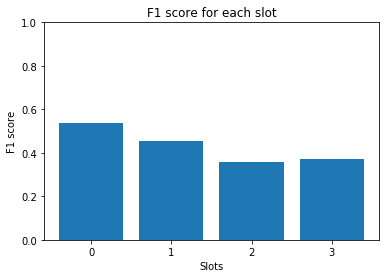

In [616]:
label = [i for i in range(len(f1_list))]
plot_bar(label, 'Slots', 'F1 score', 'F1 score for each slot', f1_list)